In [1]:
import sys
sys.path.append('/workspace/Documents')
import torch
import numpy as np
import os
import cv2
import math
import random
import pandas as pd
import nibabel as nb
import matplotlib.pylab as plt
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
from PIL import Image

from torch.utils.data import Dataset, DataLoader

import sam_cmr.Build_list_zhennong.Build_list as Build_list
import sam_cmr.Data_processing as Data_processing
import sam_cmr.dataset.CMR.random_aug_zhennong as random_aug

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define dataset

# # ACDC dataset
# data_path = '/mnt/camca_NAS/SAM_for_CMR/data/ACDC_database/temporal'
# patient_list_path = '/mnt/camca_NAS/SAM_for_CMR/data/Patient_list/'
# patient_list_file = os.path.join(patient_list_path, 'ACDC_Patient_List_training_testing.xlsx')

# # STACOM dataset
data_path = '/mnt/camca_NAS/SAM_for_CMR/data/STACOM_database'
patient_list_path = '/mnt/camca_NAS/SAM_for_CMR/data/Patient_list/'
patient_list_file = os.path.join(patient_list_path, 'STACOM_Patient_List_training_testing.xlsx')

In [5]:
# select patients based on either batch or index (don't use both!)
# for ACDC
# in total we have 100 training and 50 testing patients
# for batch (think it as the group /folds in cross validation), batch 0,1,2,3,4 are used for training and batch 5 is used for testing
# for index, we have 0-100 for training and 100-150 for testing

# for STACOM
# in total we have 100 training, divide them into 5 batches

# index_list = np.arange(99,100,1)
# batch_list = None
# or
index_list = np.arange(0,1,1)
batch_list = None
_,_,_,image_full_slice_file_list ,seg_full_slice_file_list ,image_nonzero_slice_file_list ,seg_nonzero_slice_file_list ,image_nonzero_slice_file_loose_list ,seg_nonzero_slice_file_loose_list, total_slice_num_list ,nonzero_slice_num_list, nonzero_slice_num_loose_list = Build_list.__build__(patient_list_file, batch_list = batch_list, index_list = index_list)

# select you want to use "full slice" or "nonzero slices" file
full_or_nonzero_slice = 'nonzero'

if full_or_nonzero_slice[0:4] == 'full':
    image_file_list = image_full_slice_file_list
    seg_file_list = seg_full_slice_file_list
    total_slice_num_list = total_slice_num_list
elif full_or_nonzero_slice[0:4] == 'nonz':
    image_file_list = image_nonzero_slice_file_list
    seg_file_list = seg_nonzero_slice_file_list
    total_slice_num_list = nonzero_slice_num_list

print(image_file_list, seg_file_list), print(total_slice_num_list)


['/mnt/camca_NAS/SAM_for_CMR/data/STACOM_database/temporal/DET0000101/4d_temporal_img_nonzero.nii.gz'] ['/mnt/camca_NAS/SAM_for_CMR/data/STACOM_database/temporal/DET0000101/4d_temporal_seg_nonzero.nii.gz']
[9]


(None, None)

In [6]:
class Dataset_CMR(torch.utils.data.Dataset):
    def __init__(
            self, 
            patient_list_spreadsheet_file,
            image_file_list,
            seg_file_list,
            total_slice_num_list,

            seg_include_lowest_piexel = 100, # only include the segmentation with the lowest pixel number > seg_include_lowest_piexel in one slice
            turn_zero_seg_slice_into = None, # if there is no segmentation in this slice, then turn the pixel value of this slice into 10

            return_arrays_or_dictionary = 'dictionary', # "arrays" or "dictionary"
            relabel_LV  = None, # relabel the segmentation, 0 for background, 1 for LV, 2 for MYO, 3 for RV
            only_myo = None, # only keep MYO segmentation, 0 for background, 1 for MYO, 2 for others
            center_crop_according_to_which_class  = [1],

            image_shape = None, # [x,y], channel =  tf always 15 
            shuffle = None,
            image_normalization = None,
            augment_list = [('brightness' , None),  ('contrast', None), ('sharpness', None), ('flip', None), ('rotate', [-90,90]), ('translate', [-10,10]), ('random_crop', [-5,5])], # a list of augmentation methods and their range: v range = None for brightness, contrast, sharpness
            augment_frequency = 0.3, # how often do we do augmentation

            sample_more_base = 0,
            sample_more_apex = 0,
    ):

        super().__init__()
        self.patient_list_spreadsheet = pd.read_excel(patient_list_spreadsheet_file)

        self.image_file_list = image_file_list
        self.seg_file_list = seg_file_list
        self.total_slice_num_list = total_slice_num_list

        self.seg_include_lowest_piexel = seg_include_lowest_piexel
        self.turn_zero_seg_slice_into = turn_zero_seg_slice_into

        self.relabel_LV = relabel_LV
        self.only_myo = only_myo    
        self.center_crop_according_to_which_class = center_crop_according_to_which_class

        self.image_shape = image_shape
        self.shuffle = shuffle
        self.image_normalization = image_normalization
        self.augment_list = augment_list
        self.augment_frequency = augment_frequency
        self.return_arrays_or_dictionary = return_arrays_or_dictionary

        self.sample_more_base = sample_more_base
        self.sample_more_apex = sample_more_apex

        # how many cases we have in this dataset?
        self.num_files = len(self.image_file_list)

        # how many slices in total we have in this dataset? Note each case has different number of slices
        self.num_slices_total = np.sum(self.total_slice_num_list)

        # the following two should be run at the beginning of each epoch
        # 1. get index array
        self.index_array = self.generate_index_array()
        # 2. some parameters
        self.current_image_file = None
        self.current_image_data = None 
        self.current_seg_file = None
        self.current_seg_data = None
        

    # function: we need to generate an index array for dataloader, it's a list, each element is [file_index, slice_index]
    def generate_index_array(self):
     
        np.random.seed()
        index_array = []
                
        if self.shuffle == True:
            file_index_list = np.random.permutation(self.num_files)
        else:
            file_index_list = np.arange(self.num_files)

        for i in range(0,file_index_list.shape[0]):
            file_index = file_index_list[i]
            num_slices = self.total_slice_num_list[file_index]

            if self.shuffle == True:
                s_list = np.random.permutation(num_slices)
            else:
                s_list = np.arange(num_slices)

            # add more base and apex slices (randomly sampled)
            if self.sample_more_base > 0:
                s_list = s_list.tolist() + [10000] * self.sample_more_base; s_list = np.asarray(s_list)
            if self.sample_more_apex > 0:
                s_list = s_list.tolist() + [20000] * self.sample_more_apex; s_list = np.asarray(s_list)
            
    
            for slice_index in s_list:
                index_array.append([file_index, slice_index])

        return index_array
    
    # function: load nii file, it will give you a 4D array [x, y, slice_num, tf], tf is the temporal dimension always equal to 15
    def load_file(self, filename, segmentation_load = False):
        ii = nb.load(filename).get_fdata()
        if segmentation_load is True:
            ii = np.round(ii).astype(int)
         
        if self.relabel_LV is True and segmentation_load is True:
            iii = np.zeros(ii.shape)
            iii[ii == 1] = 3
            iii[ii == 2] = 2
            iii[ii == 3] = 1
            ii = np.copy(iii)
        if self.only_myo is True and segmentation_load is True:
            iii = np.zeros(ii.shape)
            iii[ii != 2] = 0
            iii[ii == 2] = 1
            ii = np.copy(iii)
        # assert there are pixels with value = 1
        if segmentation_load is True:
            assert np.sum(ii == 1) > 0, 'there are no segmentation pixels  = 1 in this file: ' + filename
        return ii
    
    # function: how many cases do we have in this dataset? = total slice number accumulated from all cases
    def __len__(self):
        return self.num_slices_total + (self.sample_more_base + self.sample_more_apex) * self.num_files
    
    # function: get each item using the index [file_index, slice_index]
    def __getitem__(self, index):
        # print('in this geiitem, self.index_array is: ', self.index_array, ' and index is :', index)
        f,s = self.index_array[index]
        # print('index is: ', index, ' now we pick file ', f, ' and slice ', s)
        image_filename = self.image_file_list[f]
        # print('image file is: ', image_filename, ' while current image file is: ', self.current_image_file)
        seg_filename = self.seg_file_list[f]
        # print('seg file is: ', seg_filename, ' while current seg file is: ', self.current_seg_file)

        # if it's a new case, then do the data loading; if it's not, then just use the current data
        if image_filename != self.current_image_file or seg_filename != self.current_seg_file:
            # print('new image file, load')
            image_loaded = self.load_file(image_filename, segmentation_load = False) 

            self.original_shape = image_loaded[:,:,0,:].shape # [x,y,tf], before center crop

            seg_loaded = self.load_file(seg_filename, segmentation_load=True) 

            # now we need to do the center crop for both image and seg
            # we have data volume as [x, y ,slice_num,tf], for each data volume , we use the [x,y, middle_slice, 0] for the centroid calculation (0 is ED, which always has segmentation)
            _,_, self.centroid = Data_processing.center_crop( image_loaded[:,:,image_loaded.shape[2] // 2, 0], seg_loaded[:,:,image_loaded.shape[2]//2, 0], self.image_shape, according_to_which_class = self.center_crop_according_to_which_class , centroid = None)
            # print('self.centroid is: ', self.centroid)

            if any(jjj[0] == 'random_crop' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
                parameter_index = next((i for i, x in enumerate(self.augment_list) if x[0] == 'random_crop'), None)
                # a random interger in [parameter_index[0], parameter_index[1]]
                random_centriod_shift_x = np.random.randint(self.augment_list[parameter_index][1][0], self.augment_list[parameter_index][1][1])
                random_centriod_shift_y = np.random.randint(self.augment_list[parameter_index][1][0], self.augment_list[parameter_index][1][1])
                # print('random_centriod_shift is: ', random_centriod_shift_x, random_centriod_shift_y)
                centroid_used_for_crop = [self.centroid[0] + random_centriod_shift_x, self.centroid[1] + random_centriod_shift_y]
                
            else:
                centroid_used_for_crop = self.centroid

            # print('centroid_used_for_crop is: ', centroid_used_for_crop)
            
            # then for each dim in slice_num and tf, we do the center crop
            image_loaded_tem = np.zeros([self.image_shape[0],self.image_shape[1],image_loaded.shape[2],image_loaded.shape[3]])
            seg_loaded_tem = np.zeros([self.image_shape[0],self.image_shape[1],image_loaded.shape[2],image_loaded.shape[3]])
            for z_dim in range(0,image_loaded.shape[2]):
                for tf_dim in range(0,image_loaded.shape[3]):
                    image_loaded_tem[:,:,z_dim,tf_dim], seg_loaded_tem[:,:,z_dim,tf_dim], _ = Data_processing.center_crop( image_loaded[:,:,z_dim,tf_dim], seg_loaded[:,:,z_dim,tf_dim], self.image_shape, according_to_which_class = self.center_crop_according_to_which_class , centroid = centroid_used_for_crop)
            image_loaded = np.copy(image_loaded_tem)
            seg_loaded = np.copy(seg_loaded_tem)
            
            self.current_image_file = image_filename
            self.current_image_data = np.copy(image_loaded)  
            self.current_seg_file = seg_filename
            self.current_seg_data = np.copy(seg_loaded)


        # pick the slice using slice index
        if s == 10000 or s == 20000: # random sampled, 10000 for base, 20000 for apex
            if s == 10000:
                # randomly sample from [1,3]
                s = np.random.randint(1,3)
            elif s == 20000:
                # randomly sampled from [-3,-2]
                s = np.random.randint(-3,-1)
            # print('randomly sampled slice index is: ', s)
       
        original_image = np.copy(self.current_image_data)[:,:,s,:] # now it's a 3D array [x, y, tf]
        original_seg = np.copy(self.current_seg_data)[:,:,s,:]
      

        ######## do augmentation: should we do the augmentation, it's based on the self.augment_list
        processed_seg = np.copy(original_seg)
        # (0) add noise
        if any(jjj[0] == 'noise' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
            standard_deviation = 5
            processed_image = original_image + np.random.normal(0,standard_deviation,original_image.shape)
            # turn the image pixel range to [0,255]
            processed_image = Data_processing.turn_image_range_into_0_255(processed_image)
            # print('add noise')
        else:
            processed_image = Data_processing.turn_image_range_into_0_255(original_image)
            # print('no noise')
       

        # (1) do brightness
        if any(jjj[0] == 'brightness' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
            parameter_index = next((i for i, x in enumerate(self.augment_list) if x[0] == 'brightness'), None)
            processed_image,v = random_aug.random_brightness(processed_image, v = self.augment_list[parameter_index][1])
            # print('did brightness augmentation, v: ', v, ' image max: ', np.max(processed_image), ' image min: ', np.min(processed_image)  )

        # (2) do contrast
        if  any(jjj[0] == 'contrast' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
            parameter_index = next((i for i, x in enumerate(self.augment_list) if x[0] == 'contrast'), None)
            processed_image, v = random_aug.random_contrast(processed_image, v = self.augment_list[parameter_index][1])
            # print('did contrast augmentation, v: ', v, ' image max: ', np.max(processed_image), ' image min: ', np.min(processed_image))

        # (3) do sharpness
        if any(jjj[0] == 'sharpness' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
            parameter_index = next((i for i, x in enumerate(self.augment_list) if x[0] == 'sharpness'), None)
            processed_image, v = random_aug.random_sharpness(processed_image, v = self.augment_list[parameter_index][1])
            # print('did sharpness augmentation, v: ', v, ' image max: ', np.max(processed_image), ' image min: ', np.min(processed_image))
            
        # (4) do flip
        if any(jjj[0] == 'flip' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
            # doing this can make sure the flip is the same for image and seg
            a, selected_option = random_aug.random_flip(processed_image)
            b,_ = random_aug.random_flip(processed_seg, selected_option)
            processed_image = np.copy(a)
            processed_seg = np.copy(b)
            # print('did flip augmentation, selected option: ', selected_option)

        # (5) do rotate
        if any(jjj[0] == 'rotate' for jjj in self.augment_list)  and np.random.uniform(0,1)  < self.augment_frequency:
            parameter_index = next((i for i, x in enumerate(self.augment_list) if x[0] == 'rotate'), None)
            processed_image, z_rotate_degree = random_aug.random_rotate(processed_image, order = 0, z_rotate_range = self.augment_list[parameter_index][1])
            processed_seg,_ = random_aug.random_rotate(processed_seg, z_rotate_degree, fill_val = 0, order = 0)
            # print('did rotate augmentation, z_rotate_degree: ', z_rotate_degree)

        # (6) do translate
        if any(jjj[0] == 'translate' for jjj in self.augment_list) and np.random.uniform(0,1)  < self.augment_frequency:
            parameter_index = next((i for i, x in enumerate(self.augment_list) if x[0] == 'translate'), None)
            processed_image, x_translate, y_translate = random_aug.random_translate(processed_image, translate_range = self.augment_list[parameter_index][1])
            processed_seg,_ ,_= random_aug.random_translate(processed_seg, x_translate, y_translate)
            # print('did translate augmentation, x_translate: ', x_translate, ' y_translate: ', y_translate)

        # add normalization
        if self.image_normalization is True:
            processed_image = Data_processing.normalize_image(processed_image,denormalize = False) # do image normalization
            # print('did image normalization')


        # find which times frame has segmentation, and put it into annotation frame list
        # also turn the pixel value of the slice without manual segmentation into 10
        annotation_frame_list = []
        for tf in range(0,original_seg.shape[2]):
            s_i = np.copy(original_seg[:,:,tf])
            # turn pixels = 1 or 2 equal to 1 and others equal to 0
            s_i[s_i>0] = 1
            s_i[s_i>2] = 0
            if np.sum(s_i) > self.seg_include_lowest_piexel:
                annotation_frame_list.append(tf)
            else:
                # turn the pixel value of this slice in processeed seg all into turn_zero_seg_slice_into
                if self.turn_zero_seg_slice_into is not None:
                    processed_seg[:,:,tf] = self.turn_zero_seg_slice_into
        # print('annotation_frame_list is: ', annotation_frame_list)
        # print('unique value in processed seg: ', np.unique(processed_seg))
            
            
        # now it's time to turn numpy into tensor and collect as a dictionary (this is the final return)
        processed_image_torch = torch.from_numpy(processed_image).unsqueeze(0).float()
        # processed_seg_torch = torch.from_numpy(np.rollaxis(processed_seg, 2, 0))  ####### should I turn segmentation to float as well @ sekeun
        processed_seg_torch = torch.from_numpy(processed_seg).unsqueeze(0)  

        # print('processed seg torch shape: ', processed_seg_torch.shape)

        # also need to return the original image and seg without the augmentation (with center crop done)
        # original_image_torch = torch.from_numpy(np.rollaxis(original_image, 2, 0)).float()
        original_image_torch = torch.from_numpy(original_image).unsqueeze(0).float()
        # original_seg_torch = torch.from_numpy(np.rollaxis(original_seg, 2, 0))
        original_seg_torch = torch.from_numpy(original_seg).unsqueeze(0).float()

        # also add infos from patient list spread sheet
        patient_id = os.path.basename(os.path.dirname(image_filename))
        row = self.patient_list_spreadsheet.loc[self.patient_list_spreadsheet['patient_id'] == patient_id]
       
        final_dictionary = { "image": processed_image_torch, "mask": processed_seg_torch, 
                "original_image": original_image_torch,  "original_seg": original_seg_torch,
                'annotation_frame_list': annotation_frame_list,
                "image_file_name" : image_filename, "seg_file_name": seg_filename,
                "original_shape" : self.original_shape,
                "centroid": self.centroid,
                'slice_index': s,
                # copy infos from patient list spreadsheet
                "patient_id": row.iloc[0]['patient_id'],
                "patient_group": row.iloc[0]['patient_group'],
                "batch_index": row.iloc[0]['batch_index'],
                "image_full_slice_file": row.iloc[0]['image_full_slice_file'],
                "seg_full_slice_file": row.iloc[0]['seg_full_slice_file'],
                "image_nonzero_slice_file": row.iloc[0]['image_nonzero_slice_file'],
                "seg_nonzero_slice_file": row.iloc[0]['seg_nonzero_slice_file'],
                "image_nonzero_slice_file_loose": row.iloc[0]['image_nonzero_slice_file_loose'],
                "seg_nonzero_slice_file_loose": row.iloc[0]['seg_nonzero_slice_file_loose'],
                "start_slice_name": row.iloc[0]['start_slice_name'],
                "total_slice_num": row.iloc[0]['total_slice_num'],
                "nonzero_slice_num": row.iloc[0]['nonzero_slice_num'],
                "nonzero_slice_start_index": row.iloc[0]['nonzero_slice_start_index'],
                "nonzero_slice_end_index": row.iloc[0]['nonzero_slice_end_index'],
                "nonzero_slice_num_loose": row.iloc[0]['nonzero_slice_num_loose'],
                "nonzero_slice_start_index_loose": row.iloc[0]['nonzero_slice_start_index_loose'],
                "nonzero_slice_end_index_loose": row.iloc[0]['nonzero_slice_end_index_loose'],
                "processed_time_frame_num": row.iloc[0]['processed_time_frame_num'],
                "ED_index_in_processed_time_frame": row.iloc[0]['ED_index_in_processed_time_frame'],
                "ES_index_in_processed_time_frame": row.iloc[0]['ES_index_in_processed_time_frame'],
                "processed_time_frame_index_list": row.iloc[0]['processed_time_frame_index_list'],}


        if self.return_arrays_or_dictionary == 'dictionary':
            return final_dictionary
        elif self.return_arrays_or_dictionary == 'arrays':
            return processed_image_torch, processed_seg_torch # model input and label
        else:
            raise ValueError('return_arrays_or_dictionary should be "arrays" or "dictionary"')
    
    # function: at the end of each epoch, we need to reset the index array
    def on_epoch_end(self):
        print('now run on_epoch_end function')
        self.index_array = self.generate_index_array()

        self.current_image_file = None
        self.current_image_data = None 
        self.current_seg_file = None
        self.current_seg_data = None

In [134]:
# run the code
shuffle = False
dataset = Dataset_CMR(patient_list_file ,
                      image_file_list,
                      seg_file_list,
                      total_slice_num_list,
                      return_arrays_or_dictionary = 'dictionary',

                      seg_include_lowest_piexel = 100,
                      turn_zero_seg_slice_into = 10,
                      
                      relabel_LV = False,  # true for ACDC, false for STACOM
                      only_myo = False,

                      center_crop_according_to_which_class = [1], # [1] for ACDC and STACOM
                      image_shape = [128,128], 

                      shuffle = shuffle, 
                      image_normalization = True,
                      augment_list = [('noise', None),('brightness' , None), ('contrast', None), ('sharpness', None), ('flip', None), ('rotate', [-20,20]), ('translate', [-5,5]), ('random_crop', [-5,5])],
                      augment_frequency = 1,
                      
                      sample_more_base = 0,
                      sample_more_apex = 0,)

dl = DataLoader(dataset, batch_size = 1, shuffle = False, pin_memory = True, num_workers = 0)

In [135]:
def cycle(dl):
    while True:
        for data in dl:
            yield data
            
cycle_dl = cycle(dl)

count = 0
for batch in cycle_dl:
    data = batch
    count += 1

    if count == 15:
        break

in this geiitem, self.index_array is:  [[0, 8], [0, 6], [0, 3], [0, 1], [0, 7], [0, 2], [0, 0], [0, 5], [0, 4], [0, 10000], [0, 20000], [0, 20000], [0, 20000]]  and index is : 0
index is:  0  now we pick file  0  and slice  8
self.centroid is:  [95 85]
random_centriod_shift is:  6 -6
centroid_used_for_crop is:  [101, 79]
s is:  8 data type of s  <class 'numpy.int64'>
in this geiitem, self.index_array is:  [[0, 8], [0, 6], [0, 3], [0, 1], [0, 7], [0, 2], [0, 0], [0, 5], [0, 4], [0, 10000], [0, 20000], [0, 20000], [0, 20000]]  and index is : 1
index is:  1  now we pick file  0  and slice  6
s is:  6 data type of s  <class 'numpy.int64'>
in this geiitem, self.index_array is:  [[0, 8], [0, 6], [0, 3], [0, 1], [0, 7], [0, 2], [0, 0], [0, 5], [0, 4], [0, 10000], [0, 20000], [0, 20000], [0, 20000]]  and index is : 2
index is:  2  now we pick file  0  and slice  3
s is:  3 data type of s  <class 'numpy.int64'>
in this geiitem, self.index_array is:  [[0, 8], [0, 6], [0, 3], [0, 1], [0, 7], [0, 

In [126]:
data["original_image"].shape

torch.Size([1, 1, 128, 128, 15])

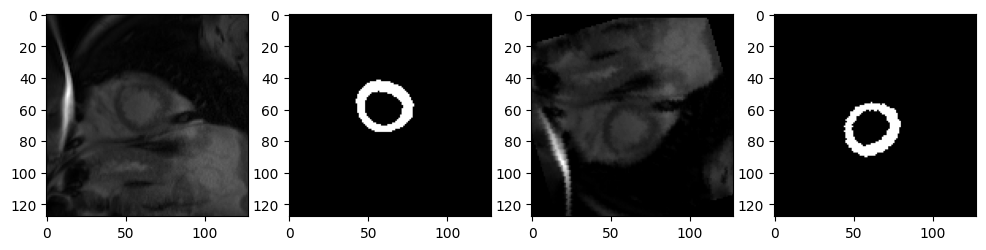

In [129]:
plt.figure(figsize=(12,3))
plt.subplot(141); plt.imshow(data["original_image"].squeeze()[:,:,0], cmap='gray')
plt.subplot(142); plt.imshow(data["original_seg"].squeeze()[:,:,0], cmap='gray')
plt.subplot(143); plt.imshow(data["image"].squeeze()[:,:,0], cmap='gray')
plt.subplot(144); plt.imshow(data["mask"].squeeze()[:,:,0], cmap='gray')

In [ ]:
torch.unique(data["mask"])